# Figures 1 and 2

Here, using XGI, we reproduce figures 1 and 2 of the paper  
"Do higher-order interactions promote synchronization?"  
Yuanzhao Zhang *, Maxime Lucas *, Federico Battiston  
[arXiv:2203.03060](https://doi.org/10.48550/arXiv.2203.03060)

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xgi
from utils import (
    compute_eigenvalues_multi,
    random_flag_complex_d2,
)

sb.set_theme(style="ticks", context="paper")

fig_dir = "figures/"
results_dir = "results/"

Path(fig_dir).mkdir(parents=True, exist_ok=True)
Path(results_dir).mkdir(parents=True, exist_ok=True)

## Fig. 1

### Generate random structures

In [3]:
N = 100  # number of nodes
ps = [
    0.1,
    0.1,
]  # ps[i] is the wiring probability of any i+2 nodes (ps[0] is for edges, e.g.)

n_repetitions = 10  # number of realisations of random structures

# generate random hypergraphs
HGs = [xgi.random_hypergraph(N, ps) for i in range(n_repetitions)]

In [4]:
# generate random simplicial complex
MSCs = [random_flag_complex_d2(N, p=0.5) for i in range(n_repetitions)]

### Compute Lyapunov exponents

In [5]:
alphas = np.arange(0, 1.01, 0.1)
n_alpha = len(alphas)

lyaps_HG = np.zeros((n_alpha, N, n_repetitions))

# compute Lyapunov exponents for all alpha values
for j, HG in enumerate(HGs):  # for all hypergraphs

    for i, alpha in enumerate(alphas):
        lyap_multi = compute_eigenvalues_multi(
            HG, orders=[1, 2], weights=[1 - alpha, alpha]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_HG[i, :, j] = lyap_multi

lyaps_MSC = np.zeros((n_alpha, N, n_repetitions))

# compute Lyapunov exponents for all alpha values
for j, MSC in enumerate(MSCs):  # for all simplicial complexes

    for i, alpha in enumerate(alphas):
        lyap_multi = compute_eigenvalues_multi(
            MSC, orders=[1, 2], weights=[1 - alpha, alpha]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_MSC[i, :, j] = lyap_multi

In [6]:
# average and std over the random realisations
# consider the second largest exponents only
means_HG = np.mean(lyaps_HG[:, 1, :], axis=1)
std_HG = np.std(lyaps_HG[:, 1, :], axis=1)

means_MSC = np.mean(lyaps_MSC[:, 1, :], axis=1)
std_MSC = np.std(lyaps_MSC[:, 1, :], axis=1)

### Plot results

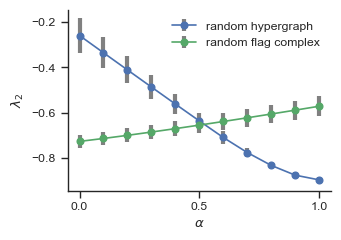

In [7]:
fig, ax = plt.subplots(figsize=(3.4, 2.35))

ax.errorbar(
    alphas,
    means_HG,
    yerr=std_HG,
    fmt="-o",
    color="C0",
    ecolor="gray",
    elinewidth=3,
    capsize=0,
    label="random hypergraph",
)

ax.errorbar(
    alphas,
    means_MSC,
    yerr=std_MSC,
    fmt="-o",
    color="C2",
    ecolor="gray",
    elinewidth=3,
    capsize=0,
    label="random flag complex",
)

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_xticks([0, 0.5, 1])

sb.despine()
ax.legend(frameon=False)

fig_name = f"figure_1_lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()

## Fig. 2

### Generate random structures and compute exponents

In [8]:
N = 50  # number of nodes

p_1s = [0.2, 0.4, 0.6, 0.8]  # wiring probability of 1-hyperedges
p_2 = 0.05  # wiring probability of 2-hyperedges
alphas = np.arange(0, 1.01, 0.05)

HGs_2 = []
lyaps_HG_2 = np.zeros((len(p_1s), len(alphas), N))

for j, p_1 in enumerate(p_1s):

    ps = [
        p_1,
        p_2,
    ]  # ps[i] is the wiring probability of any i+2 nodes (ps[0] is for edges, e.g.)

    # generate hyperedges
    HG = xgi.random_hypergraph(N, ps, seed=0)
    HGs_2.append(HG)

    # compute exponents
    for i, alpha in enumerate(alphas):
        lyap_multi = compute_eigenvalues_multi(
            HG, orders=[1, 2], weights=[1 - alpha, alpha]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_HG_2[j, i, :] = lyap_multi

In [9]:
def bound_multi(H, alpha, rescale_per_node=True):
    """Returns the lower bound N/(N-1) k_min

    Parameters
    ----------
    HG : xgi.HyperGraph
        Hypergraph
    orders : list of int
        Orders of interactions to consider.
    weights: list of float
        Weight of each order, i.e coupling strenghts gamma_i in [1]_.
    rescale_per_node: bool, (default=False)
        Whether to rescale each Laplacian of order d by d (per node).

    Returns
    -------
    float, bound of the Lyapunov exponent
    """
    L_multi = xgi.multiorder_laplacian(
        H, orders=[1, 2], weights=[1 - alpha, alpha], rescale_per_node=rescale_per_node
    )
    K_multi = np.diag(L_multi)
    N = H.num_nodes
    return -(N / (N - 1)) * np.min(K_multi)

In [10]:
# compute theoretical bound
bound = np.array([bound_multi(HGs_2[-1], alpha) for alpha in alphas])

### Plot results

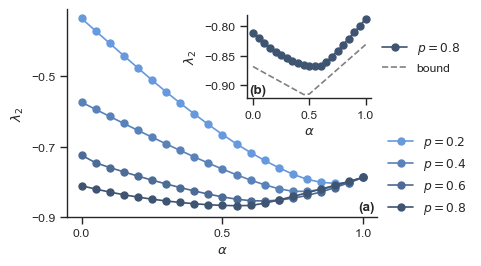

In [13]:
fig, ax = plt.subplots(figsize=(3.4, 2.35))

# set gradient palette (might need to re-run to make it effective)
palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

# plot curves
for i, p_1 in enumerate(p_1s):
    ax.plot(alphas, lyaps_HG_2[i, :, 1], "o-", label=f"$p={p_1:.1f}$", ms=5)

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

ax.set_yticks([-0.5, -0.7, -0.9])
ax.set_xticks([0, 0.5, 1])

ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.2))

# add inset with bound
# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(ax, width="40%", height="40%")
k = 3
axins.plot(
    alphas, lyaps_HG_2[k, :, 1], "o-", c=f"C{k}", label=f"$p={p_1s[k]:.1f}$", ms=5
)
axins.plot(alphas, bound, "--", label="bound", c="grey")

axins.set_ylabel(r"$\lambda_2$")
axins.set_xlabel(r"$\alpha$")
# axins.set_yticklabels([])

axins.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

sb.despine()

ax.text(
    0.99, 0.02, "(a)", transform=ax.transAxes, va="bottom", ha="right", weight="bold"
)
axins.text(
    0.015, 0.03, "(b)", transform=axins.transAxes, va="bottom", ha="left", weight="bold"
)

fig_name = f"figure_2_phase_diagram_lines_p2_{p_2}"
# plt.savefig(f"{fig_name}.pdf", dpi=250, bbox_inches="tight")

plt.show()